This code tests the efficiency of the quantum processing unit with and without its entangling gates. For each processing unit, the accuracy it is able to achieve is compared to the current epoch iteration, which demonstrates how many epochs it takes for each to achieve its highest possible level of accuracy. This provides a measure of each units efficiency.  The test is run 100 times, and an averaged loss plot is produced for the entangled quantum and non-entangled classical case. 

In [1]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"


In [2]:
#setting main hyperparameters of the model 
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 6              # Number of samples for each training step
num_epochs = 20            # Number of training epochs
q_depth = 6                # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

#initialise pennylane
dev = qml.device("default.qubit", wires=n_qubits)

#configure pytorch 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

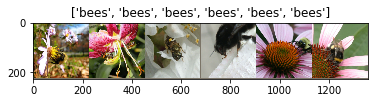

In [3]:
#Transform Data and define training and test data 
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = r"C:\Users\cassi\_data\hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

        
        #Let us show a batch of the test data, just to have an idea of the classification problem.

# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}


In [4]:
#Variational Quantum Circuit 

def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])


In [5]:
#Define Quantum Circuit 

@qml.qnode(dev, interface="torch")
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


In [6]:
#Dressed Quantum Circuit (primes data for QPU and to be extraced out the other end)
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """
# use linear layer to reduce 512 to 4. 
        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

#optimise features of linear reduction 
        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_net(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [7]:
#Hybrid Quantum Model (As designed by Xanadu)
model_hybridQ = torchvision.models.resnet18(pretrained=True)

for param in model_hybridQ.parameters():
    param.requires_grad = False


# # Notice that model_hybrid.fc is the last layer of ResNet18
model_hybridQ.fc = DressedQuantumNet()

# # Use CUDA or CPU according to the "device" object.
# model_hybrid = model_hybrid.to(device)

In [8]:
#Define Quantum Circuit without CNOT gates 

@qml.qnode(dev, interface="torch")
def quantum_netL(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)


In [9]:
#Quantum Layer Circuit without CNOT gates 
class LinearCircuit(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """
# use linear layer to reduce 512 to 4. 
        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

#optimise features of linear reduction 
        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_netL(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [10]:
#Comparison model without CNOT Gates  
model_classicalL = torchvision.models.resnet18(pretrained=True)

for param in model_classicalL.parameters():
    param.requires_grad = False


# # Notice that model_hybrid.fc is the last layer of ResNet18
model_classicalL.fc = LinearCircuit()

# # Use CUDA or CPU according to the "device" object.
# model_hybrid = model_hybrid.to(device)

In [11]:
#Training and Results 

#Added to the Origonal code is an empty vector for the train and test accuracy to be appended to at every epoch 


#We use, as usual in classification problem, the cross-entropy which is directly available within torch.nn.
criterion = nn.CrossEntropyLoss()

#We also initialize the Adam optimizer which is called at each training step in order to update the weights of the model.
optimizer_hybridQ = optim.Adam(model_hybridQ.fc.parameters(), lr=step)
optimizer_classicalL = optim.Adam(model_classicalL.fc.parameters(), lr=step)
#We schedule to reduce the learning rate by a factor of gamma_lr_scheduler every 10 epochs.
exp_lr_schedulerQ = lr_scheduler.StepLR(
    optimizer_hybridQ, step_size=10, gamma=gamma_lr_scheduler
)
exp_lr_schedulerL = lr_scheduler.StepLR(
    optimizer_classicalL, step_size=10, gamma=gamma_lr_scheduler
)

#Training and Classification 

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    resultA=[]
    resultB=[]    
    
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training (runs backwards from last layer and optimises over all layers )
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )
            if phase == 'train':
                resultA.append(epoch_loss)
            if phase == 'validation':
                resultB.append(epoch_loss)

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return best_acc_train, best_acc

Training started:
Phase: train Epoch: 1/2 Loss: 0.6924 Acc: 0.5164        
Phase: validation   Epoch: 1/2 Loss: 0.6913 Acc: 0.5033        
Phase: train Epoch: 2/2 Loss: 0.6868 Acc: 0.5164        
Phase: validation   Epoch: 2/2 Loss: 0.6917 Acc: 0.5163        
Training completed in 0m 59s
Best test loss: 0.6913 | Best test accuracy: 0.5163
Training started:
Phase: train Epoch: 1/2 Loss: 0.7426 Acc: 0.4631        
Phase: validation   Epoch: 1/2 Loss: 0.7292 Acc: 0.5033        
Phase: train Epoch: 2/2 Loss: 0.7526 Acc: 0.4672        
Phase: validation   Epoch: 2/2 Loss: 0.7254 Acc: 0.5033        
Training completed in 1m 1s
Best test loss: 0.7254 | Best test accuracy: 0.5033


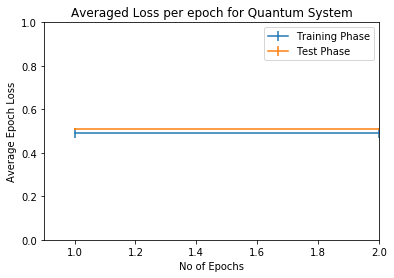

In [14]:
#Train the model, average and plot thee results  for the Quantum Case 
N=100
ResultTrainQ=np.zeros((N,num_epochs))
ResultTestQ=np.zeros((N,num_epochs))
for i in range(N):

    [ResultTrainQ[i], ResultTestQ[i]] = train_model(model_hybridQ, criterion, optimizer_hybridQ, exp_lr_schedulerQ, num_epochs=num_epochs)
    model_hybridQ = torchvision.models.resnet18(pretrained=True)
    
    for param in model_hybridQ.parameters():
        param.requires_grad = False
    
    # # Notice that model_hybrid.fc is the last layer of ResNet18
    model_hybridQ.fc = DressedQuantumNet()     

ResultTrainQ_avg = np.zeros(num_epochs)
ResultTrainQ_std = np.zeros(num_epochs)
for i in range(num_epochs):
    ResultTrainQ_avg[i]=np.average(ResultTrainQ[:,i])
    ResultTrainQ_std[i]=np.std(ResultTrainQ[:,i])
    
ResultTestQ_avg = np.zeros(num_epochs)
ResultTestQ_std = np.zeros(num_epochs)
for i in range(num_epochs):
    ResultTestQ_avg[i]=np.average(ResultTestQ[:,i])
    ResultTestQ_std[i]=np.std(ResultTestQ[:,i])


x=np.linspace(1,num_epochs,num_epochs)
plt.errorbar(x,ResultTrainQ_avg, yerr=ResultTrainQ_std, label='Training Phase')
plt.errorbar(x,ResultTestQ_avg, yerr=ResultTestQ_std, label='Test Phase')
plt.xlabel('No of Epochs')
plt.ylabel('Average Epoch Loss')
plt.title('Averaged Loss per epoch for Quantum System')
plt.xlim([0.9,num_epochs])
plt.ylim([0,1])
plt.legend()

Training started:
Phase: train Epoch: 1/2 Loss: 0.6955 Acc: 0.4959        
Phase: validation   Epoch: 1/2 Loss: 0.6634 Acc: 0.5425        
Phase: train Epoch: 2/2 Loss: 0.6613 Acc: 0.4959        
Phase: validation   Epoch: 2/2 Loss: 0.6135 Acc: 0.5425        
Training completed in 1m 16s
Best test loss: 0.6135 | Best test accuracy: 0.5425
Training started:
Phase: train Epoch: 1/2 Loss: 0.6826 Acc: 0.5615        
Phase: validation   Epoch: 1/2 Loss: 0.6750 Acc: 0.5882        
Phase: train Epoch: 2/2 Loss: 0.6759 Acc: 0.5697        
Phase: validation   Epoch: 2/2 Loss: 0.6844 Acc: 0.5817        
Training completed in 1m 18s
Best test loss: 0.6750 | Best test accuracy: 0.5882


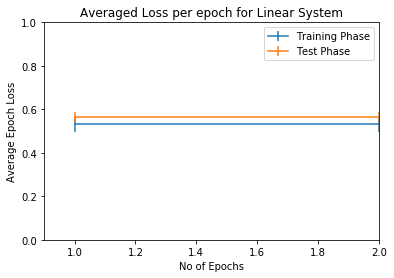

In [13]:
#Train the model, average and plot thee results  for the without CNOT Case 

N=100
ResultTrainL=np.zeros((N,num_epochs))
ResultTestL=np.zeros((N,num_epochs))
for i in range(N):

    [ResultTrainL[i], ResultTestL[i]] = train_model(model_classicalL, criterion, optimizer_classicalL, exp_lr_schedulerL, num_epochs=num_epochs)
    model_classicalL = torchvision.models.resnet18(pretrained=True)
    
    for param in model_classicalL.parameters():
        param.requires_grad = False
    
    # # Notice that model_hybrid.fc is the last layer of ResNet18
    model_classicalL.fc = LinearCircuit()     

ResultTrainL_avg = np.zeros(num_epochs)
ResultTrainL_std = np.zeros(num_epochs)
for i in range(num_epochs):
    ResultTrainL_avg[i]=np.average(ResultTrainL[:,i])
    ResultTrainL_std[i]=np.std(ResultTrainL[:,i])
    
ResultTestL_avg = np.zeros(num_epochs)
ResultTestL_std = np.zeros(num_epochs)
for i in range(num_epochs):
    ResultTestL_avg[i]=np.average(ResultTestL[:,i])
    ResultTestL_std[i]=np.std(ResultTestL[:,i])


x=np.linspace(1,num_epochs,num_epochs)
plt.errorbar(x,ResultTrainL_avg, yerr=ResultTrainL_std, label='Training Phase')
plt.errorbar(x,ResultTestL_avg, yerr=ResultTestL_std, label='Test Phase')
plt.xlabel('No of Epochs')
plt.ylabel('Average Epoch Loss')
plt.title('Averaged Loss per epoch for Linear System')
plt.xlim([0.9,num_epochs])
plt.ylim([0,1])
plt.legend()

